### Wellcome to EDA work

El proposito de este notebook es el de explorar los datos a traves de la agregacion de estos.

Datasets:
- review-001.json: Reseñas de usuarios.
- user-002.parquet: 
- business.pickle
- Python_gmaps_metada
- Python_Datasets_gmpas_reviews

Los retos son:

* Archivos muy pesados.
* Diferentes formatos en los datasets.
* Tal vez algo de limpieza y transformacion.


Herramientas ocupadas

* Polars - Lazy Frames (under SQL context)
* Pandas - Data Frames
* PySpark - Tables (Also under SQL context)

In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

### Google Reviews

Este dataset es parquet contiene casi 90 millones de registros. Estos son solo las reseñas de los usuarios donde este se relaciona con el dataset de metadata. En metadata se elabora mas columnas que serivran para poder filtrar nuestra data y asi dar breves reportes.

Debido a que es un dara set muy pesado, esto solo es posible con pyarrow. Es una libreria cuya 

In [13]:
directorio_google_reviews = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\google_maps\\Python_Datasets_gmpas_reviews.parquet"

google_reviews = pq.read_table(directorio_google_reviews)

Hasta este paso, el dataset cargado a googlereviews es relativamente ligero, al menos en la PC consume poco arriba de 3.5 GB.. al pasarlo a pandas es cuando hay un consumo significante quedando la variable incluso en 34 GB.. no se si esto queda almacenado en la RAM, pero se convierte en un dataset muy pesado. Despues de tener el pandas, asignar `None` a la variable `google_reviews` para liberar un poco.

![imagen](C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\imagenes\\sprint_1\\eda_etl\\consumo_pandas.JPG)

In [14]:
google_reviews_df = google_reviews.to_pandas()
google_reviews_df.shape

In [4]:
google_reviews_df.dtypes

user_id    float64
name        object
time         int64
rating       int64
text        object
pics        object
resp        object
gmap_id     object
dtype: object

Libera espacio en la variable `google_reviews`

In [5]:
google_reviews = None

Para hacer operaciones mas rapido en el dataframe de pandas es recomendable usar el backend de pyarrow para el tipo de dato haciendo lo siguiente (puede demorar algunos minutos)

In [6]:
google_reviews_df = google_reviews_df.convert_dtypes(dtype_backend="pyarrow")
google_reviews_df.dtypes

c:\Users\jdieg\Desktop\henry\proyectos\Google-Yelp\.proyecto_final_env\lib\site-packages\pandas\core\dtypes\cast.py:1056: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\jdieg\Desktop\henry\proyectos\Google-Yelp\.proyecto_final_env\lib\site-packages\pandas\core\dtypes\cast.py:1080: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


user_id    double[pyarrow]
name       string[pyarrow]
time        int64[pyarrow]
rating      int64[pyarrow]
text       string[pyarrow]
pics                object
resp                object
gmap_id    string[pyarrow]
dtype: object

Y se puede intentar hacer una conversion por ejemplo de las fechas unix (columna time) a fechas normales

In [7]:
google_reviews_df.head()

,user_id,name,time,rating,text,pics,resp,gmap_id
0,1.140438e+20,Kanisha Mixon,1597168272670,5,Very Personable staff! Beautiful and clean env...,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
1,1.160090e+20,Brandie Hodges,1609899039594,5,Best clothing intown,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
2,1.062399e+20,Sharon King,1547235290843,4,<NA>,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
3,1.049701e+20,Veronica Pierce,1517709403534,5,<NA>,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
4,1.105875e+20,Whitney Waldon Collier,1535245718492,5,<NA>,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf


In [8]:
google_reviews_df["time"] = pd.to_datetime(google_reviews_df["time"], unit="ms")

In [9]:
google_reviews_df["time"]

0          2020-08-11 17:51:12.670
1          2021-01-06 02:10:39.594
2          2019-01-11 19:34:50.843
3          2018-02-04 01:56:43.534
4          2018-08-26 01:08:38.492
                     ...          
89946354   2021-03-03 03:15:23.428
89946355   2019-06-30 21:58:31.835
89946356   2017-07-26 00:36:06.785
89946357   2019-08-10 19:54:20.108
89946358   2020-04-19 13:20:38.249
Name: time, Length: 89946359, dtype: datetime64[ns]

Y solo demoro 9.8 segundos convertir 89,946,359 registros. Esto convence que pyarrow sera una buena herramienta para la exploratoria de datos. Invito ampliamente a conocer a fondo las bondades de esta API de python que se esta empleando [pyarrow](https://arrow.apache.org/docs/python/index.html).

NO OLVIDES CONVERTIR NUEVAS COLUMNAS A pyarrow BACKEND!

aunque esto es solo para numericos (enteros y decimales, conocidos en arrow int y double respectivamente) y cadena de caracteres (texto)

In [10]:
google_reviews_df["time"].convert_dtypes(dtype_backend="pyarrow")
google_reviews_df.dtypes

user_id    double[pyarrow]
name       string[pyarrow]
time        datetime64[ns]
rating      int64[pyarrow]
text       string[pyarrow]
pics                object
resp                object
gmap_id    string[pyarrow]
dtype: object

### Nulos

En porcentaje en cada columna

In [122]:
def proporcion_nulos(data_frame:pd.DataFrame):
    """
    Calculate the percentage of null (missing) values in each column of a Pandas DataFrame.

    Parameters:
    data_frame (pd.DataFrame): The input DataFrame for which null percentages are calculated.

    Returns:
    pd.Series: A Pandas Series containing the percentage of null values for each column.
    """
    return data_frame.isnull().sum() / data_frame.shape[0] * 100

In [12]:
proporcion_nulos(google_reviews_df)

user_id     0.000000
name        0.000000
time        0.000000
rating      0.000000
text       43.701318
pics       97.225370
resp       87.738125
gmap_id     0.000000
dtype: float64

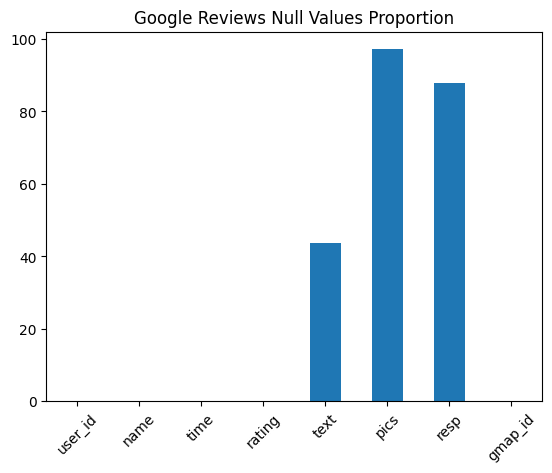

In [13]:
proporcion_nulos(google_reviews_df).plot(kind="bar", rot=45, title="Google Reviews Null Values Proportion");

Ciertamente hay columnas con un considerable porcentaje de valores nulos.

In [14]:
google_reviews_df.drop(["pics", "resp"], axis=1, inplace=True)

In [15]:
google_reviews_df.head()

,user_id,name,time,rating,text,gmap_id
0,1.140438e+20,Kanisha Mixon,2020-08-11 17:51:12.670,5,Very Personable staff! Beautiful and clean env...,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
1,1.160090e+20,Brandie Hodges,2021-01-06 02:10:39.594,5,Best clothing intown,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
2,1.062399e+20,Sharon King,2019-01-11 19:34:50.843,4,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
3,1.049701e+20,Veronica Pierce,2018-02-04 01:56:43.534,5,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
4,1.105875e+20,Whitney Waldon Collier,2018-08-26 01:08:38.492,5,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf


In [16]:
google_reviews_df["time"].min(), google_reviews_df["time"].max()

(Timestamp('1990-12-31 00:00:00'), Timestamp('2021-09-09 16:22:53.205000'))

In [17]:
google_reviews_df["year"] = google_reviews_df["time"].dt.year

In [18]:
google_reviews_df["year"] = google_reviews_df["year"].convert_dtypes(dtype_backend="pyarrow")

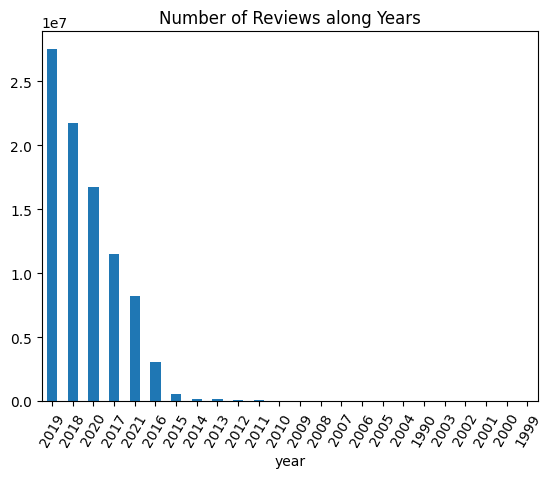

In [19]:
google_reviews_df["year"].value_counts().plot(kind="bar", rot=60, title="Number of Reviews along Years");

In [20]:
(google_reviews_df["year"] > 2011).sum()

89851857

In [21]:
google_reviews_df.shape[0] - (google_reviews_df["year"] > 2011).sum()

94502

In [22]:
chunk_size = 9000000

chunks = [google_reviews_df[idx_pos: idx_pos + chunk_size] for idx_pos in range(0, len(google_reviews_df), chunk_size)]

result_df = pd.DataFrame()

for chunk in chunks:
    chunk = chunk[chunk["year"] > 2011]
    result_df = pd.concat([result_df, chunk], ignore_index=True)

In [23]:
chunks = None

In [24]:
google_reviews_df = result_df

In [25]:
proporcion_nulos(google_reviews_df)

user_id     0.000000
name        0.000000
time        0.000000
rating      0.000000
text       43.695738
gmap_id     0.000000
year        0.000000
dtype: float64

In [26]:
google_reviews_df

,user_id,name,time,rating,text,gmap_id,year
0,1.140438e+20,Kanisha Mixon,2020-08-11 17:51:12.670,5,Very Personable staff! Beautiful and clean env...,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2020
1,1.160090e+20,Brandie Hodges,2021-01-06 02:10:39.594,5,Best clothing intown,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2021
2,1.062399e+20,Sharon King,2019-01-11 19:34:50.843,4,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2019
3,1.049701e+20,Veronica Pierce,2018-02-04 01:56:43.534,5,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2018
4,1.105875e+20,Whitney Waldon Collier,2018-08-26 01:08:38.492,5,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2018
...,...,...,...,...,...,...,...
89851852,1.078991e+20,Carlene Calabaza,2021-03-03 03:15:23.428,5,<NA>,0x53349429523d615b:0x2a66a9272032e8b4,2021
89851853,1.173878e+20,Gizmo,2019-06-30 21:58:31.835,5,<NA>,0x53349429523d615b:0x2a66a9272032e8b4,2019
89851854,1.078871e+20,Jan Soucek,2017-07-26 00:36:06.785,5,<NA>,0x53349429523d615b:0x2a66a9272032e8b4,2017
89851855,1.047652e+20,Kyle Leatherow,2019-08-10 19:54:20.108,3,<NA>,0x53349429523d615b:0x2a66a9272032e8b4,2019


### I quick view on the count of ratings

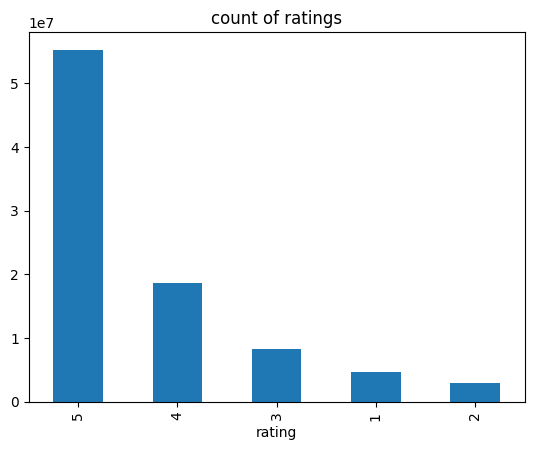

In [27]:
google_reviews_df["rating"].value_counts().plot(kind="bar", rot=90, title="count of ratings");

In [28]:
google_maps__folder_path = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\google_maps"
google_reviews_df.to_parquet(google_maps__folder_path + "\\google_reviews.parquet")

### Metadata

A comparacion de gmaps_review, este parquet es relativamente mas ligero, siendo pandas capaz de la lectura de el archivo parquet

In [29]:
directorio_metadata_reviews =  "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\google_maps\\Python_gmaps_metada.parquet"

metada_reviews_df = pd.read_parquet(directorio_metadata_reviews).convert_dtypes(dtype_backend="pyarrow")
metada_reviews_df.dtypes

name                string[pyarrow]
address             string[pyarrow]
gmap_id             string[pyarrow]
description         string[pyarrow]
latitude            double[pyarrow]
longitude           double[pyarrow]
category                     object
avg_rating          double[pyarrow]
num_of_reviews       int64[pyarrow]
price               string[pyarrow]
hours                        object
MISC                         object
state               string[pyarrow]
relative_results             object
url                 string[pyarrow]
dtype: object

In [30]:
metada_reviews_df.shape

(3025011, 15)

(<Axes: title={'center': 'Null Proportion ofor Metadata'}>,
 name                 0.001223
 address              2.661511
 gmap_id              0.000000
 description         91.593783
 latitude             0.000000
 longitude            0.000000
 category             0.575833
 avg_rating           0.000000
 num_of_reviews       0.000000
 price               90.902413
 hours               26.029823
 MISC                22.837405
 state               24.676109
 relative_results     9.753948
 url                  0.000000
 dtype: float64)

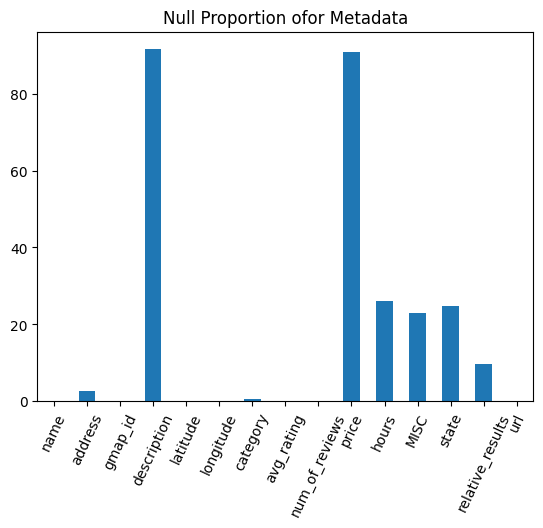

In [31]:
proporcion_nulos(metada_reviews_df).plot(kind="bar", rot=65, title="Null Proportion ofor Metadata"),proporcion_nulos(metada_reviews_df)

In [32]:
metada_reviews_df.drop(["description", "price"], axis=1, inplace=True)

### Getting States

In [33]:
proporcion_nulos(metada_reviews_df)

name                 0.001223
address              2.661511
gmap_id              0.000000
latitude             0.000000
longitude            0.000000
category             0.575833
avg_rating           0.000000
num_of_reviews       0.000000
hours               26.029823
MISC                22.837405
state               24.676109
relative_results     9.753948
url                  0.000000
dtype: float64

First, let's get rid off null on address rows

In [34]:
metada_reviews_df = metada_reviews_df[~metada_reviews_df["address"].isna()]

Then, builgind up our lambdas expresion on small porcion for testing

In [35]:
small_metadata = metada_reviews_df[:200]

In [36]:
(
    small_metadata["address"]
    # Get address element
    .apply(lambda row: [address_element.strip() for address_element in row.split(",")][-1])
    # Get the element of City
    .apply(lambda x: x.split()[0].strip())

    )

0      GA
1      CA
2      CA
3      CA
4      CA
       ..
205    FL
206    CA
207    ID
208    TX
210    TX
Name: address, Length: 200, dtype: object

In [37]:
metada_reviews_df["us_state"] = (
    metada_reviews_df["address"]
    # Get address element
    .apply(lambda row: [address_element.strip() for address_element in row.split(",")][-1])
    # Get the element of City
    .apply(lambda x: x.split()[0])

    )

In [38]:
metada_reviews_df["us_state"]

0          GA
1          CA
2          CA
3          CA
4          CA
           ..
3025006    IL
3025007    CA
3025008    WY
3025009    AZ
3025010    WY
Name: us_state, Length: 2944500, dtype: object

In [39]:
usps_state_abbreviations = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}


In [40]:
(state_code for state_code in usps_state_abbreviations.keys())

<generator object <genexpr> at 0x00000197A44FB840>

In [41]:
us_states_set = set(list(usps_state_abbreviations.keys()))

In [42]:
metada_reviews_df = metada_reviews_df[metada_reviews_df["us_state"].apply(lambda state: state in us_states_set)]

In [43]:
metada_reviews_df.shape

(2875143, 14)

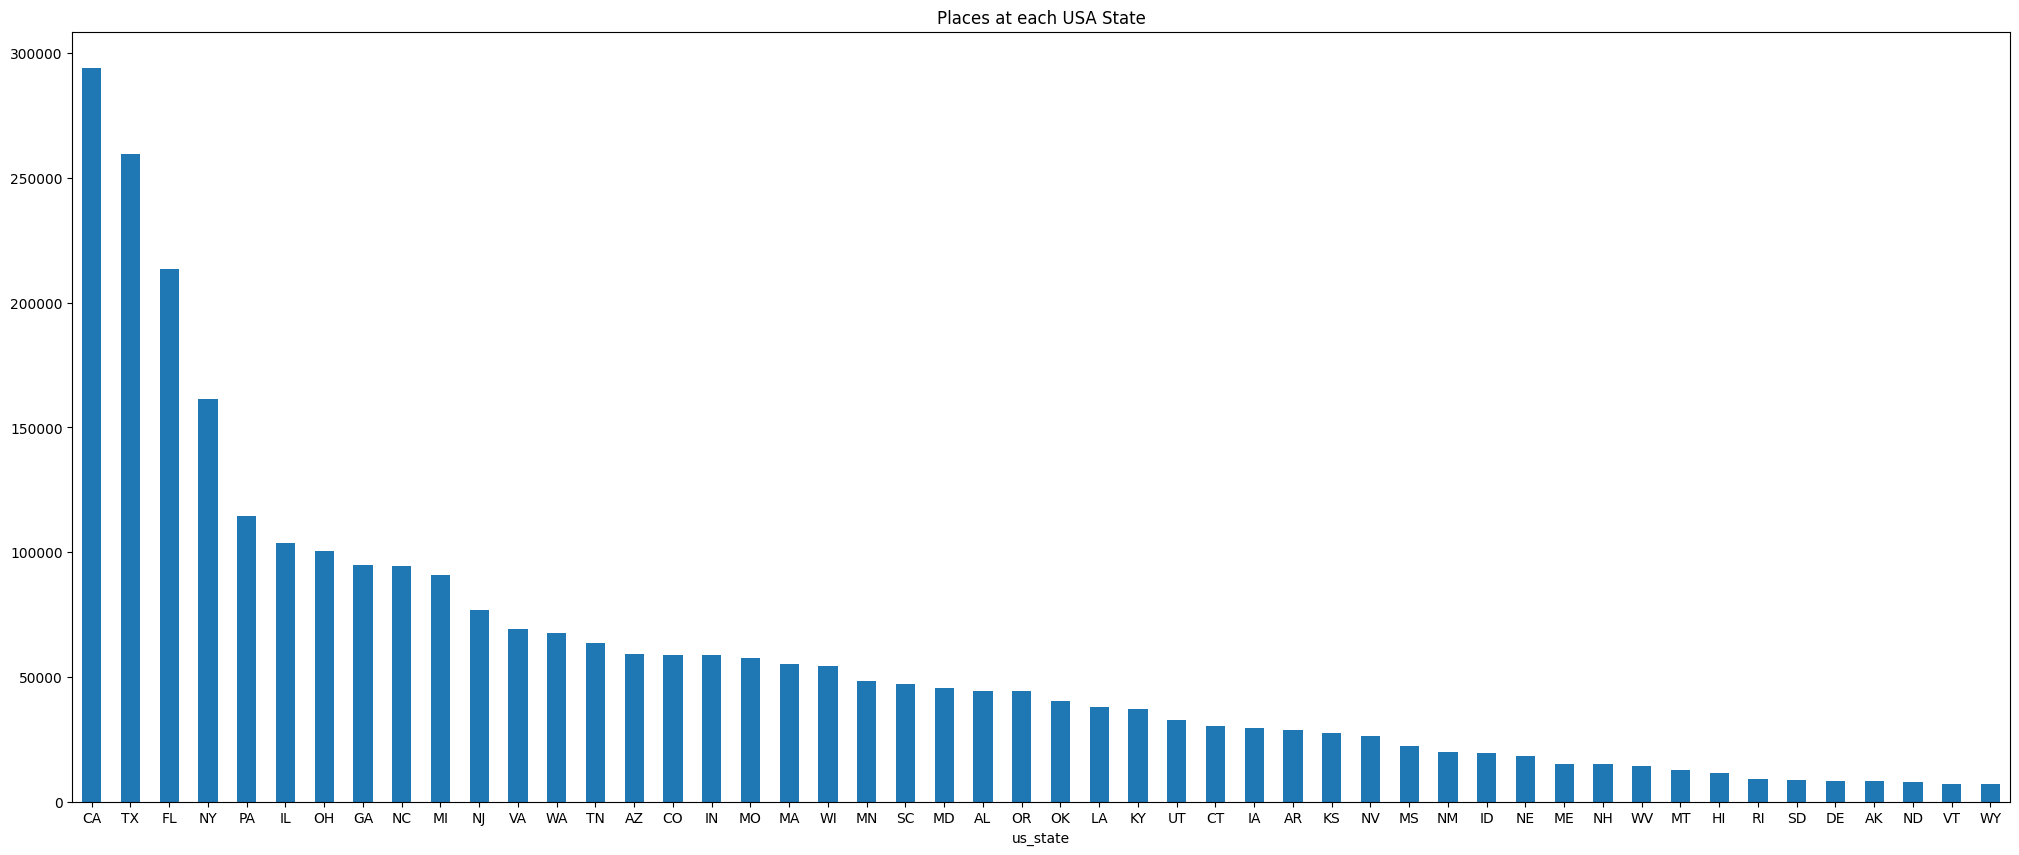

In [44]:
metada_reviews_df["us_state"].value_counts().plot(kind="bar", figsize=(25, 10), rot=0, title="Places at each USA State");

In [45]:
usps_state_abbreviations["MS"]

'Mississippi'

### Categories

Getting rid off nulls

In [46]:
proporcion_nulos(metada_reviews_df)

name                 0.000000
address              0.000000
gmap_id              0.000000
latitude             0.000000
longitude            0.000000
category             0.591449
avg_rating           0.000000
num_of_reviews       0.000000
hours               25.886086
MISC                20.858232
state               24.486469
relative_results     8.697411
url                  0.000000
us_state             0.000000
dtype: float64

Number of nulls

In [47]:
metada_reviews_df["category"].isnull().sum()

17005

In [48]:
metada_reviews_df.dropna(subset="category", axis=0, inplace=True)

In [50]:
set_categories = {"Restaurant", "Bar", "bakery", "seafood", "Fast food restaurant", "Cafe", "Hamburger Restaurant",
                  "Family Restaurant","ice cream shop", "Chinese restaurant", "Italian restaurant", "Vegetarian Restaurant"
                   "Japanese restaurant", "Bistro", "Mexican restaurant", "Grill", "Dessert Restaurant"
                   "Greek restaurant", "Thai restaurant", "Indian restaurant", "Spanish restaurant",
                   "British restaurant", "Tex-mex restaurant", "American restaurant",
                   "Health food restaurant", "Delivery restaurant", "Brunch restaurant",
                   "Sandwich shop", "Fast food restaurant", "Cake shop", "Chicken restaurant",
                   "Donut shop", "Coffee shop", "Southern restaurant (US)", "Juice shop", "Breakfast restaurant",
                   "Pizza restaurant", "Bar & grill, Burrito restaurant", "Pizza", "Diner", "Takeout restaurant",
                   "Sushi restaurant", "Hamburger restaurant", "Steak house", "Asian restaurant", "New American restaurant", "Singaporean Restaurant"}

mask_categories = metada_reviews_df["category"].apply(lambda categories: [category.lower().strip() in set_categories for category in categories].count(True) > 0)

In [51]:
metada_reviews_df = metada_reviews_df[mask_categories]

In [268]:
metadata_output_parquet_dir = "C:\\Users\\jdieg\\Desktop\\henry\proyectos\\Google-Yelp\\.data\\google_maps"
metada_reviews_df.to_parquet(metadata_output_parquet_dir + "\\metadata_google_reviews.parquet")

In [252]:
metada_reviews_df.shape, google_reviews_df.shape

((223863, 14), (89851857, 7))

In [57]:
proporcion_nulos(metada_reviews_df), metada_reviews_df.shape

(name                 0.000000
 address              0.000000
 gmap_id              0.000000
 latitude             0.000000
 longitude            0.000000
 category             0.000000
 avg_rating           0.000000
 num_of_reviews       0.000000
 hours               11.970714
 MISC                 0.698642
 state               11.519099
 relative_results    18.386692
 url                  0.000000
 us_state             0.000000
 dtype: float64,
 (223863, 14))

### Joining google revies to metadata

In [4]:
google_maps__folder_path = 'C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\google_maps'

In [2]:
import dask.dataframe as dd

metadata_left_ddf = dd.read_parquet(google_maps__folder_path + "\\metadata_google_reviews.parquet", npartitions=10)
google_reviews_right_ddf = dd.read_parquet(google_maps__folder_path + "\\google_reviews.parquet", npartitions=10)

result_ddf = metadata_left_ddf.merge(google_reviews_right_ddf, on="gmap_id", how="left")

result_ddf = result_ddf.compute()

In [5]:
result_ddf.to_parquet(google_maps__folder_path + "\\metadata_google_joined.parquet")

In [8]:
result_ddf.columns

Index(['name_x', 'address', 'gmap_id', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'hours', 'MISC', 'state',
       'relative_results', 'url', 'us_state', 'user_id', 'name_y', 'time',
       'rating', 'text', 'year'],
      dtype='object')

In [9]:
result_ddf.head(4)

,name_x,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,hours,MISC,state,relative_results,url,us_state,user_id,name_y,time,rating,text,year
0,Flock and Stock,"Flock and Stock, 615 Channelside Dr, Tampa, FL...",0x88c2c5c515fa6e53:0xee4f630ca314fe01,27.943383,-82.44751,['Restaurant'],2.8,52,"[array(['Wednesday', '11AM–11PM'], dtype=objec...",{'Accessibility': array(['Wheelchair accessibl...,Open ⋅ Closes 11PM,['0x88c2c5056de83ac1:0x620ac50153c61f98'],https://www.google.com/maps/place//data=!4m2!3...,FL,1.097755e+20,N,2021-02-14 02:06:09.716,4,The chicken was a little dry and they need to ...,2021
1,Flock and Stock,"Flock and Stock, 615 Channelside Dr, Tampa, FL...",0x88c2c5c515fa6e53:0xee4f630ca314fe01,27.943383,-82.44751,['Restaurant'],2.8,52,"[array(['Wednesday', '11AM–11PM'], dtype=objec...",{'Accessibility': array(['Wheelchair accessibl...,Open ⋅ Closes 11PM,['0x88c2c5056de83ac1:0x620ac50153c61f98'],https://www.google.com/maps/place//data=!4m2!3...,FL,1.154786e+20,Amaury Suarez,2021-07-17 01:47:22.482,3,A fried chicken place that is always out of ch...,2021
2,Flock and Stock,"Flock and Stock, 615 Channelside Dr, Tampa, FL...",0x88c2c5c515fa6e53:0xee4f630ca314fe01,27.943383,-82.44751,['Restaurant'],2.8,52,"[array(['Wednesday', '11AM–11PM'], dtype=objec...",{'Accessibility': array(['Wheelchair accessibl...,Open ⋅ Closes 11PM,['0x88c2c5056de83ac1:0x620ac50153c61f98'],https://www.google.com/maps/place//data=!4m2!3...,FL,1.053001e+20,Meghin Hagley,2019-07-15 01:42:14.912,2,Pictures look better then what you get. The Di...,2019
3,Flock and Stock,"Flock and Stock, 615 Channelside Dr, Tampa, FL...",0x88c2c5c515fa6e53:0xee4f630ca314fe01,27.943383,-82.44751,['Restaurant'],2.8,52,"[array(['Wednesday', '11AM–11PM'], dtype=objec...",{'Accessibility': array(['Wheelchair accessibl...,Open ⋅ Closes 11PM,['0x88c2c5056de83ac1:0x620ac50153c61f98'],https://www.google.com/maps/place//data=!4m2!3...,FL,1.146867e+20,Justin Mooney,2021-03-27 17:26:56.058,5,The prices here are pretty reasonable and you ...,2021


In [10]:
## Codigo peligroso.
# result_ddf.groupby("us_state").aggregate(["sum", "mean", "max", "min"])

### Reading parquet file joined with pandas powered by pyarrow back-end

In [5]:
metadata_google_reviews = pd.read_parquet(google_maps__folder_path + "\\metadata_google_joined.parquet", engine="pyarrow", dtype_backend="pyarrow")

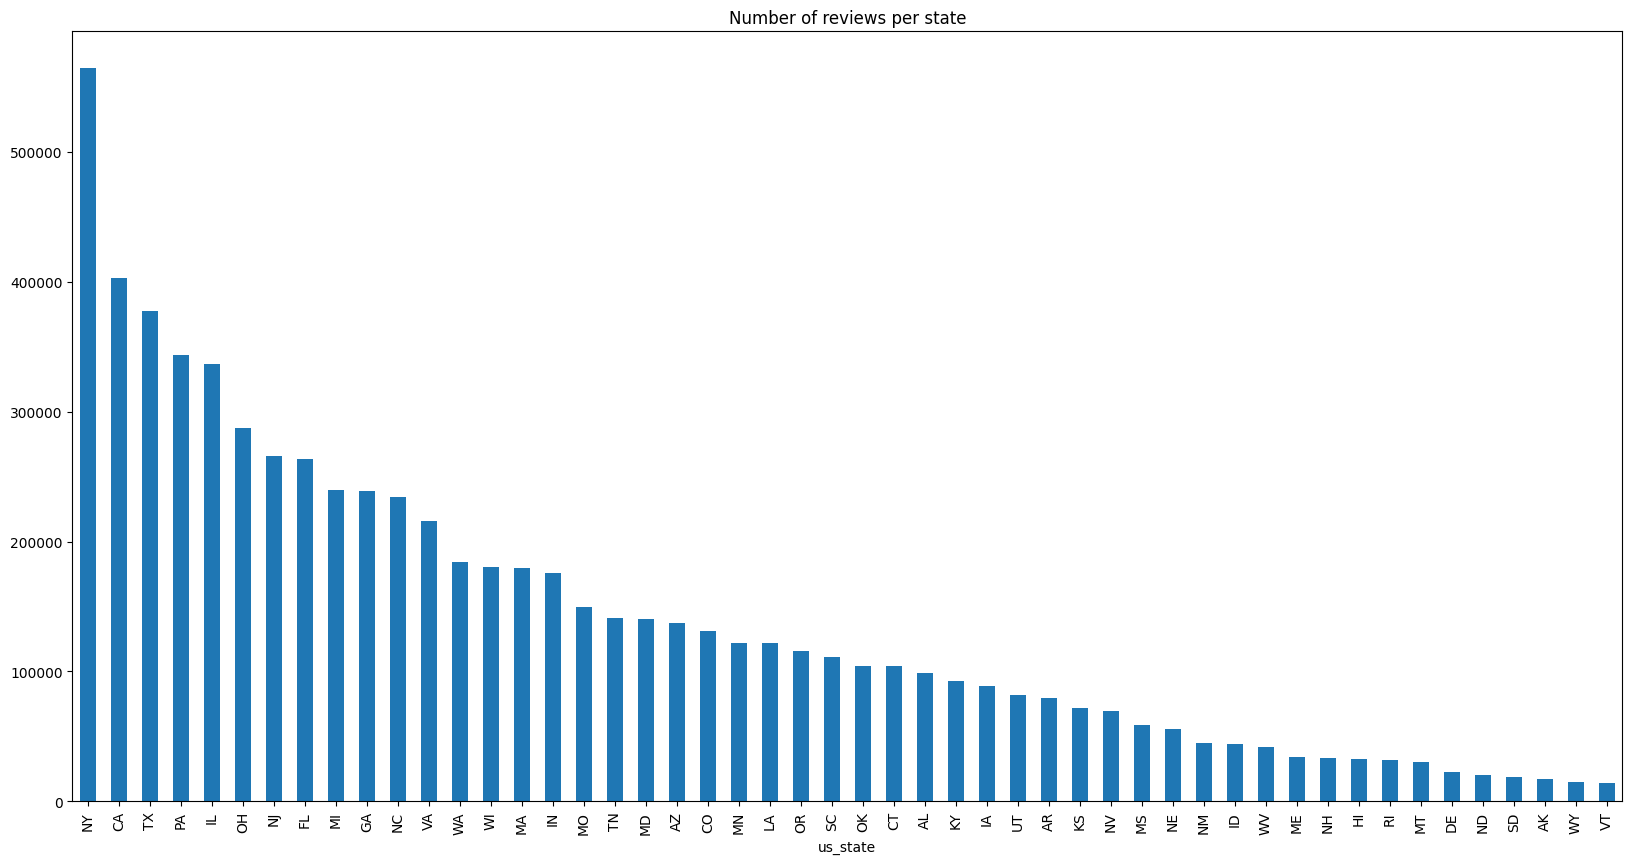

In [13]:
metadata_google_reviews["us_state"].value_counts().plot(kind="bar", title="Number of reviews per state", figsize=(20, 10));

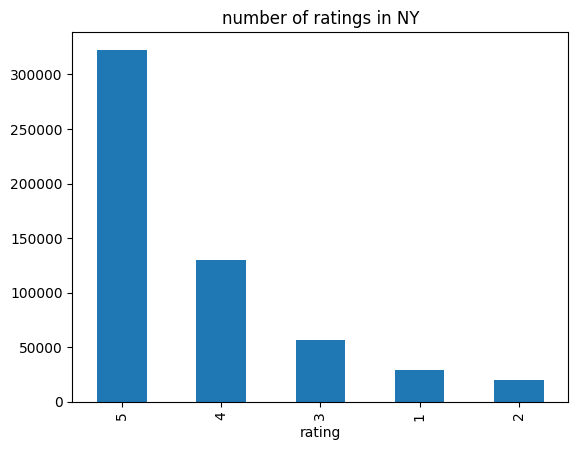

In [17]:
metadata_google_reviews.loc[metadata_google_reviews["us_state"] == "NY", "rating"].value_counts().plot(kind="bar", title="number of ratings in NY");

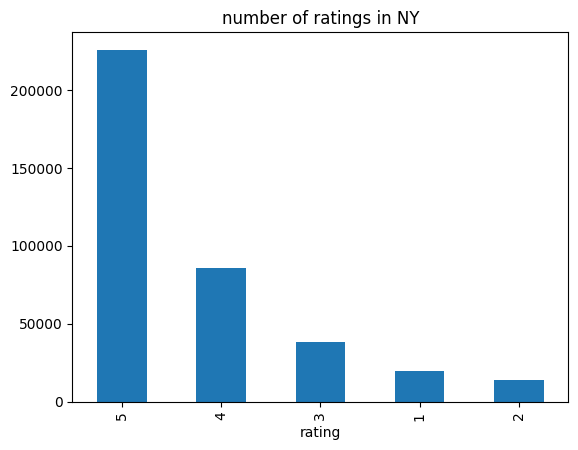

In [18]:
metadata_google_reviews.loc[metadata_google_reviews["us_state"] == "CA", "rating"].value_counts().plot(kind="bar", title="number of ratings in NY");

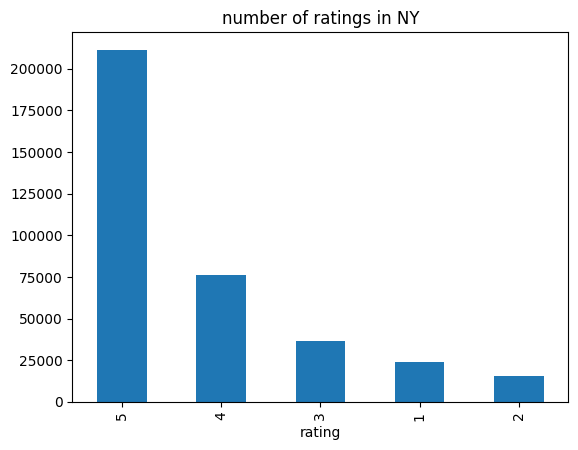

In [20]:
metadata_google_reviews.loc[metadata_google_reviews["us_state"] == "TX", "rating"].value_counts().plot(kind="bar", title="number of ratings in NY");

In [5]:
metadata_google_reviews.head()

NameError: name 'metadata_google_reviews' is not defined

In [ ]:
chuck_size = 900000

google_reviews_chunks = [google_reviews_df[idx_google: idx_google + chunk_size] for idx_google in range(0, len(google_reviews_df), chuck_size)]

merged_df = pd.DataFrame()

for chunk in google_reviews_chunks:
    merged_chunk = metada_reviews_df.merge(chunk, on="gmap_id", how="left")
    merged_df = pd.concat([merged_df, merged_chunk], ignore_index=True)

This checks locations with coordinates

In [83]:
# from geopy.geocoders import Nominatim
# from geopy.exc import GeocoderTimedOut

In [84]:
# geolocator = Nominatim(user_agent="reverse_geocoding_example")


In [113]:
# # Define a function for reverse geocoding
# def reverse_geocode(lat, lon):
#     try:
#         location = geolocator.reverse((lat, lon), exactly_one=True)
#         if location is not None:
#             address = location.address
#             return address
#         else:
#             return "Location not found"
#     except GeocoderTimedOut:
#         return reverse_geocode(lat, lon)
#     except IndexError:
#         return "Unknown State"



### Chunkenizer

In [104]:
###################################### Snipped Code ###########################################
# # Define chunk size
# chunk_size = 10000

# # Split DataFrames into chunks
# left_chunks = [left_df[i:i+chunk_size] for i in range(0, len(left_df), chunk_size)]
# right_chunks = [right_df[i:i+chunk_size] for i in range(0, len(right_df), chunk_size)]

# # Initialize an empty result DataFrame
# result_df = pd.DataFrame()

# # Iterate through chunks and merge
# for left_chunk, right_chunk in zip(left_chunks, right_chunks):
#     merged_chunk = pd.merge(left_chunk, right_chunk, on='key', how='inner')
#     result_df = pd.concat([result_df, merged_chunk], ignore_index=True)

# # result_df contains the merged result

### Working on Yelp Folder

In [15]:
yelp_folder_path= "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\yelp"

yelp_review_df = pd.read_json(yelp_folder_path + "\\review-001.json", lines=True, engine="pyarrow", dtype_backend="pyarrow")

In [19]:
yelp_review_df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [20]:
yelp_review_df["year"] = yelp_review_df["date"].dt.year
yelp_review_df["month"] = yelp_review_df["date"].dt.month

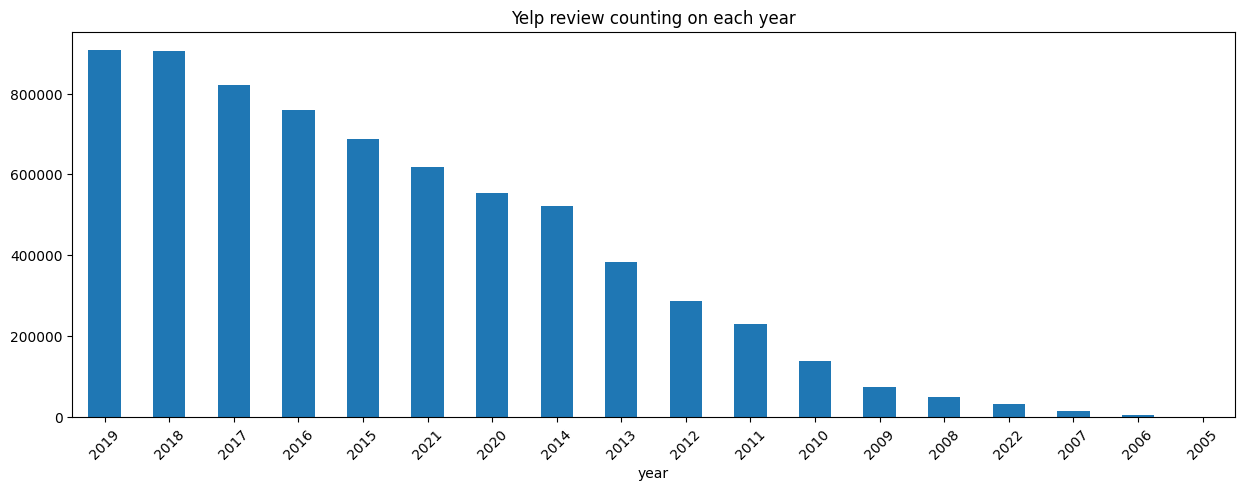

In [22]:
yelp_review_df["year"].value_counts().plot(kind="bar", 
                                      rot=45, 
                                      title="Yelp review counting on each year", 
                                      figsize=(15, 5));

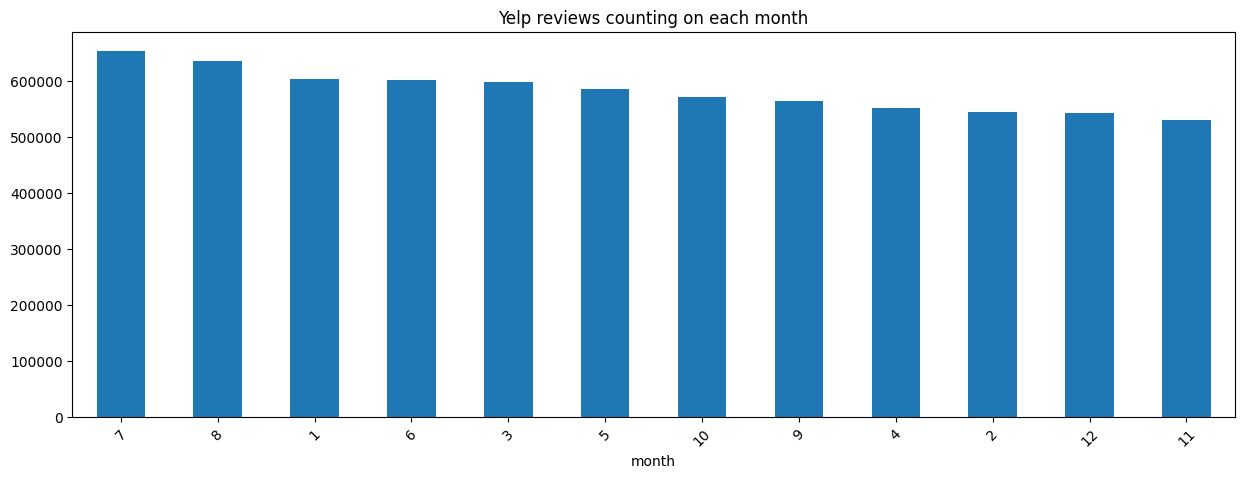

In [26]:
yelp_review_df["month"].value_counts().plot(kind="bar", 
                                      rot=45, 
                                      title="Yelp reviews counting on each month", 
                                      figsize=(15, 5));

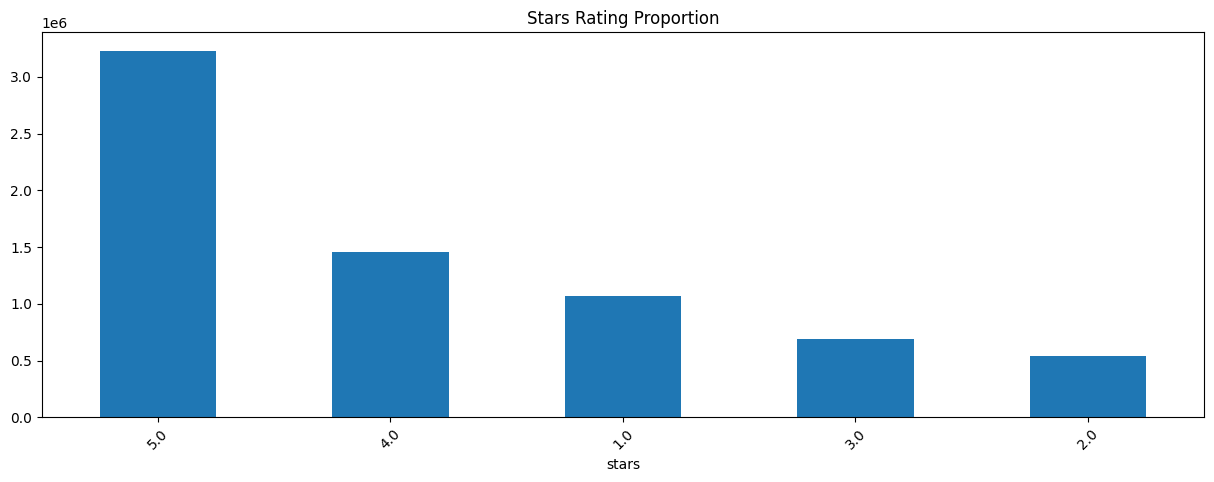

In [27]:
yelp_review_df["stars"].value_counts().plot(kind="bar", 
                                      rot=45, 
                                      title="Stars Rating Proportion", 
                                      figsize=(15, 5));

It may be good idea to have a llok at time.. do customers tend to leave 5 stars rating in morning, evening, night? lets find out

In [61]:
yelp_review_df["date"].dt.hour

0          22
1          15
2          20
3           0
4          20
           ..
6990275    21
6990276    16
6990277     3
6990278    18
6990279    22
Name: date, Length: 6990280, dtype: int64[pyarrow]

Creating bins and labels

![time category](https://qph.cf2.quoracdn.net/main-qimg-f3b2e5427d4c7bcdb2dd4c0c2d71383f)

In [91]:
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening', "Night"] 
time_bins = [0, 6, 12, 18, 22, 24]

yelp_review_df["time_category"] = pd.cut(yelp_review_df["date"].dt.hour, bins=time_bins, labels=time_labels, ordered=False, include_lowest=True)

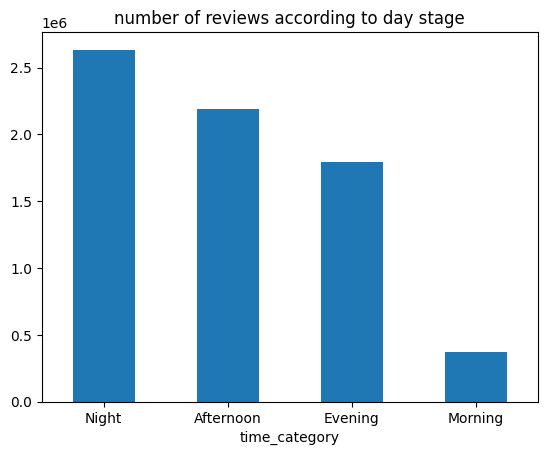

In [96]:
yelp_review_df["time_category"].value_counts().plot(kind="bar", 
                                                    title="number of reviews according to day stage",
                                                    rot=0,
                                                    );

In [99]:
yelp_review_df["time_category"]

0            Evening
1          Afternoon
2            Evening
3              Night
4            Evening
             ...    
6990275      Evening
6990276    Afternoon
6990277        Night
6990278    Afternoon
6990279      Evening
Name: time_category, Length: 6990280, dtype: category
Categories (4, object): ['Afternoon', 'Evening', 'Morning', 'Night']

In [106]:
yelp_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 12 columns):
 #   Column         Dtype                
---  ------         -----                
 0   review_id      string[pyarrow]      
 1   user_id        string[pyarrow]      
 2   business_id    string[pyarrow]      
 3   stars          double[pyarrow]      
 4   useful         int64[pyarrow]       
 5   funny          int64[pyarrow]       
 6   cool           int64[pyarrow]       
 7   text           string[pyarrow]      
 8   date           timestamp[s][pyarrow]
 9   year           int64[pyarrow]       
 10  month          int64[pyarrow]       
 11  time_category  category             
dtypes: category(1), double[pyarrow](1), int64[pyarrow](5), string[pyarrow](4), timestamp[s][pyarrow](1)
memory usage: 4.6 GB


In [111]:
yelp_review_df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,month,time_category
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,2018,7,Evening
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,2012,1,Afternoon
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2014,2,Evening
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,2015,1,Night
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,2017,1,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0,1,2,1,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20,2014,12,Evening
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10,2021,3,Afternoon
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,1,0,0,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30,2019,12,Night
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19 18:59:27,2022,1,Afternoon


### Business Dataset

In [113]:
yelp_business_path = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\yelp\\Yelp-20230922T024530Z-003\\Yelp\\business.pkl"


business_df = pd.read_pickle(yelp_business_path)

In [114]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
business_df.shape

(150346, 28)

In [33]:
business_df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'business_id', 'name', 'address',
       'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars',
       'review_count', 'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

It seems there are a few duplicated column names... Wha do they contain?

In [34]:
business_df.isna().sum()

business_id          0
name                 0
address              0
city                 0
state                3
postal_code          0
latitude             0
longitude            0
stars                0
review_count         0
is_open              0
attributes       13744
categories         103
hours            23223
business_id     150341
name            150341
address         150341
city            150341
state           150341
postal_code     150341
latitude        150341
longitude       150341
stars           150341
review_count    150341
is_open         150341
attributes      150341
categories      150341
hours           150341
dtype: int64

Certianly, null values only.. but.. that null values counting is bit smaller that the total records.. there should be data to be saved.

Indeed, 5 records that somehow the duplicated columns are not empty.. but.. hw it's happened? I do not know, I let's save this for a while since that question does not belong to the scope

In [35]:
business_df[~business_df.iloc[:,-1].isna()]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
590,6_Zf2QsRHCH1RhbzA9inyw,Starbucks,8602 Hillsborough Ave,Tampa,LA,33615,27.99637,-82.580954,3.0,56,...,LA,33615,27.99637,-82.580954,3.0,56,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Coffee & Tea, Food","{'Monday': '5:30-21:0', 'Tuesday': '5:30-21:0'..."
613,Iipfa9Kaac9XH5Vo8GQwvg,Starbucks,5956 153 Avenue,Edmonton,PA,T5Y 2W1,53.616147,-113.432424,3.5,10,...,PA,T5Y 2W1,53.616147,-113.432424,3.5,10,1,"{'BusinessParking': '{'garage': False, 'street...","Coffee & Tea, Food","{'Monday': '5:30-22:0', 'Tuesday': '5:30-22:0'..."
978,oY6osC4Ch3PvguA7D1hh_w,Starbucks,1251 Route 130 S,Cinnaminson,AZ,08077,40.000157,-74.987313,4.5,7,...,AZ,08077,40.000157,-74.987313,4.5,7,1,"{'WiFi': 'u'free'', 'BusinessParking': '{'gara...","Coffee & Tea, Food","{'Monday': '5:30-20:0', 'Tuesday': '5:30-20:0'..."
1296,pxuMxh5oC7W-PDN9wwvozg,Starbucks,219 N Center St,Reno,FL,89501,39.527772,-119.812518,3.0,44,...,FL,89501,39.527772,-119.812518,3.0,44,0,"{'BikeParking': 'False', 'Caters': 'False', 'O...","Coffee & Tea, Food","{'Monday': '5:30-19:0', 'Tuesday': '5:30-19:0'..."
1543,lo2VbA7Lwzu3i23pQpmzlw,Starbucks,"1125 S Black Horse Pike, Space 575",Gloucester Township,NJ,08012,39.78403,-75.05207,3.0,15,...,NJ,08012,39.78403,-75.05207,3.0,15,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","Food, Coffee & Tea","{'Monday': '0:0-0:0', 'Tuesday': '10:30-20:0',..."


but.. do these duplicated columns hold same information?

The following output indicates, they do..

In [36]:
business_df[~business_df.iloc[:,-1].isna()]["categories"] # -> It seems this rows holds same information

,categories,categories
590,"Coffee & Tea, Food","Coffee & Tea, Food"
613,"Coffee & Tea, Food","Coffee & Tea, Food"
978,"Coffee & Tea, Food","Coffee & Tea, Food"
1296,"Coffee & Tea, Food","Coffee & Tea, Food"
1543,"Food, Coffee & Tea","Food, Coffee & Tea"


So let's just drop those duplicated columns.. how? by dropping "na"s through columns whose null values are more than 150k.. but this threshold will add up the null values for the duplicated name columns.. for example.. columns "attributes" one only holds 13477 missing values, and the other one it is almost completely empty.. well, the threshold will drop both columns unfortunataly u.u I think due to column column ambiguity.. so.. getting rid off ambiguity is goint to be essential

* attributes       13744
* categories         103
* hours            23223

In [37]:
business_df["attributes"].iloc[:,0].fillna("{'Attribute': 'Unknown'}",inplace=True)
business_df["categories"].iloc[:,0].fillna("Unknown Category", inplace=True)
business_df["hours"].iloc[:,0].fillna("Unknown Hours", inplace=True)

In [38]:
business_df["attributes"].iloc[:,0].fillna("{'Attribute': 'Unknown'}", inplace=True)

In [39]:
business_df["attributes"].isna().sum()

attributes     13744
attributes    150341
dtype: int64

In [40]:
business_columns = business_df.columns[:14]
business_columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [41]:
business_df.loc[business_df["attributes"].iloc[:,0].isna(), "attributes"].iloc[:,0] = "No attributes"

In [42]:
business_df.columns = range(len(business_df.columns))

In [43]:
business_df.drop(business_df.loc[:,14:].columns, axis=1, inplace=True)

In [44]:
business_df.isna().sum()

0         0
1         0
2         0
3         0
4         3
5         0
6         0
7         0
8         0
9         0
10        0
11    13744
12      103
13    23223
dtype: int64

In [45]:
business_df.columns = business_columns[:14]

In [60]:
business_df["categories"] = (business_df["categories"].astype(str).apply(lambda x: x.split(",")).
                                apply(lambda x: [x_.strip() for x_ in x]))

In [64]:
business_restaurant_df = business_df[business_df["categories"].apply(lambda x: "Restaurants" in x)]

### Saving business into parquet file after dropping duplicated columns

In [46]:
#Firt of all, let's have a loot at the output
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [47]:
# business_df.to_parquet(path="data/yelp/business.parquet")

### Loading filtered business parquet

In [373]:
yelp_business_parquet_path = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\yelp\\business_restaurante.parquet"
business_df = pd.read_parquet(yelp_business_parquet_path, engine="pyarrow", dtype_backend="pyarrow")

In [374]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52268 entries, 0 to 52267
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [375]:
proporcion_nulos(business_df)

business_id      0.000000
name             0.000000
address          0.000000
city             0.000000
state            0.000000
postal_code      0.000000
latitude         0.000000
longitude        0.000000
stars            0.000000
review_count     0.000000
is_open          0.000000
attributes       1.080967
categories       0.000000
hours           13.924390
dtype: float64

In [376]:
business_df.dropna(subset="attributes", inplace=True)

In [377]:
proporcion_nulos(business_df)

business_id      0.000000
name             0.000000
address          0.000000
city             0.000000
state            0.000000
postal_code      0.000000
latitude         0.000000
longitude        0.000000
stars            0.000000
review_count     0.000000
is_open          0.000000
attributes       0.000000
categories       0.000000
hours           13.591088
dtype: float64

### Workin on BusinessParking nested dictonary inside Attributes Column
Due to nested dictionary on BusinessParking key, we can handle this by creating a new column for it

In [378]:
business_df["kind_of_parking"] = business_df["attributes"].apply(lambda attributes: attributes["BusinessParking"])

In [379]:
business_df["kind_of_parking"][0]

"{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"

Checking nulls on new columns created

In [380]:
business_df["kind_of_parking"].isnull().sum()

6092

Visualizing real "nulls"

In [381]:
business_df.loc[business_df["kind_of_parking"].isnull(), "kind_of_parking"]

10       None
15       None
27       None
29       None
41       None
         ... 
52234    None
52239    None
52243    None
52251    None
52256    None
Name: kind_of_parking, Length: 6092, dtype: object

In [382]:
business_df["kind_of_parking"].fillna("{'Unknown': True}", inplace=True)

In [383]:
business_df["kind_of_parking"].isna().sum()

0

Filling string Nulls ("None")

In [384]:
business_df["kind_of_parking"][1]

'None'

In [385]:
business_df.loc[business_df["kind_of_parking"] == "None","kind_of_parking"] = "{'Unknown': True}"

In [386]:
business_df[business_df["kind_of_parking"].isnull()]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,kind_of_parking


This is only a string, grabbing as an dict it will be necesary

In [387]:
import ast

def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return None

In [388]:
business_df["kind_of_parking"] = business_df["kind_of_parking"].apply(safe_literal_eval)

In [389]:
business_df["kind_of_parking"][0], type(business_df["kind_of_parking"][0])

({'garage': False,
  'street': True,
  'validated': False,
  'lot': False,
  'valet': False},
 dict)

In [390]:
business_df["kind_of_parking"]

0        {'garage': False, 'street': True, 'validated':...
1                                        {'Unknown': True}
2        {'garage': False, 'street': False, 'validated'...
3        {'garage': False, 'street': False, 'validated'...
4        {'garage': False, 'street': False, 'validated'...
                               ...                        
52263    {'garage': False, 'street': False, 'validated'...
52264    {'garage': False, 'street': False, 'validated'...
52265    {'garage': None, 'street': True, 'validated': ...
52266    {'garage': False, 'street': True, 'validated':...
52267    {'garage': False, 'street': False, 'validated'...
Name: kind_of_parking, Length: 51703, dtype: object

In [391]:
business_df["kind_of_parking"].isna().sum()

0

Grabbing Parking Lots Types that holds True

In [392]:
def filter_attr_bool(dict):

    filtered_dict = {}

    # Iterate through the items of the original dictionary
    for key, value in dict.items():
        # Check if the value is 'True' (as a string) and add it to the filtered dictionary
        if value == 'True':
            filtered_dict[key] = value
        elif value == True:
            filtered_dict[key] = value
    
    return filtered_dict
    


In [395]:
business_df["kind_of_parking"] = (business_df["kind_of_parking"]
                                  .apply(lambda parking_lot: filter_attr_bool(parking_lot))
                                  .apply(lambda parking: list(parking)))

In [403]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,kind_of_parking
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...",['Restaurants' 'Food' 'Bubble Tea' 'Coffee & T...,"{'Friday': '7:0-21:0', 'Monday': '7:0-20:0', '...",[street]
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,AZ,37015,36.269593,-87.058943,2.0,6,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...",['Burgers' 'Fast Food' 'Sandwiches' 'Food' 'Ic...,"{'Friday': '9:0-0:0', 'Monday': '0:0-0:0', 'Sa...",[Unknown]
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,TN,63123,38.565165,-90.321087,3.0,19,0,"{'AcceptsInsurance': None, 'AgesAllowed': None...",['Pubs' 'Restaurants' 'Italian' 'Bars' 'Americ...,<NA>,[lot]
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,MO,37207,36.208102,-86.768170,1.5,10,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...",['Ice Cream & Frozen Yogurt' 'Fast Food' 'Burg...,"{'Friday': '6:0-16:0', 'Monday': '0:0-0:0', 'S...",[]
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,MO,33602,27.955269,-82.456320,4.0,10,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...",['Vietnamese' 'Food' 'Restaurants' 'Food Trucks'],"{'Friday': '11:0-14:0', 'Monday': '11:0-14:0',...",[]


Working on attributes

Grabbing Attributes that holds True

Attribute Column -Dictionary Schema-

In [406]:
business_df["attributes"][0]

{'AcceptsInsurance': None,
 'AgesAllowed': None,
 'Alcohol': "u'none'",
 'Ambience': None,
 'BYOB': None,
 'BYOBCorkage': None,
 'BestNights': None,
 'BikeParking': 'True',
 'BusinessAcceptsBitcoin': None,
 'BusinessAcceptsCreditCards': 'False',
 'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
 'ByAppointmentOnly': 'False',
 'Caters': 'True',
 'CoatCheck': None,
 'Corkage': None,
 'DietaryRestrictions': None,
 'DogsAllowed': None,
 'DriveThru': None,
 'GoodForDancing': None,
 'GoodForKids': None,
 'GoodForMeal': None,
 'HairSpecializesIn': None,
 'HappyHour': None,
 'HasTV': None,
 'Music': None,
 'NoiseLevel': None,
 'Open24Hours': None,
 'OutdoorSeating': 'False',
 'RestaurantsAttire': None,
 'RestaurantsCounterService': None,
 'RestaurantsDelivery': 'False',
 'RestaurantsGoodForGroups': None,
 'RestaurantsPriceRange2': '1',
 'RestaurantsReservations': None,
 'RestaurantsTableService': None,
 'RestaurantsTakeOut': 'True',
 'Sm

In [407]:
business_df["attributes"]

0        {'AcceptsInsurance': None, 'AgesAllowed': None...
1        {'AcceptsInsurance': None, 'AgesAllowed': None...
2        {'AcceptsInsurance': None, 'AgesAllowed': None...
3        {'AcceptsInsurance': None, 'AgesAllowed': None...
4        {'AcceptsInsurance': None, 'AgesAllowed': None...
                               ...                        
52263    {'AcceptsInsurance': None, 'AgesAllowed': None...
52264    {'AcceptsInsurance': None, 'AgesAllowed': None...
52265    {'AcceptsInsurance': None, 'AgesAllowed': None...
52266    {'AcceptsInsurance': None, 'AgesAllowed': None...
52267    {'AcceptsInsurance': None, 'AgesAllowed': None...
Name: attributes, Length: 51703, dtype: struct<AcceptsInsurance: string, AgesAllowed: string, Alcohol: string, Ambience: string, BYOB: string, BYOBCorkage: string, BestNights: string, BikeParking: string, BusinessAcceptsBitcoin: string, BusinessAcceptsCreditCards: string, BusinessParking: string, ByAppointmentOnly: string, Caters: string, CoatCheck:

In [408]:
business_df["attributes"] = business_df["attributes"].apply(lambda attributes:  filter_attr_bool(attributes))

In [411]:
business_df["attributes"] = business_df["attributes"].apply(lambda attributes: list(attributes))

In [412]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,kind_of_parking
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"[BikeParking, Caters, RestaurantsTakeOut]",['Restaurants' 'Food' 'Bubble Tea' 'Coffee & T...,"{'Friday': '7:0-21:0', 'Monday': '7:0-20:0', '...",[street]
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,AZ,37015,36.269593,-87.058943,2.0,6,1,"[BusinessAcceptsCreditCards, DriveThru, GoodFo...",['Burgers' 'Fast Food' 'Sandwiches' 'Food' 'Ic...,"{'Friday': '9:0-0:0', 'Monday': '0:0-0:0', 'Sa...",[Unknown]
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,TN,63123,38.565165,-90.321087,3.0,19,0,"[BusinessAcceptsCreditCards, Caters, GoodForKi...",['Pubs' 'Restaurants' 'Italian' 'Bars' 'Americ...,<NA>,[lot]
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,MO,37207,36.208102,-86.768170,1.5,10,1,"[BusinessAcceptsCreditCards, DriveThru, GoodFo...",['Ice Cream & Frozen Yogurt' 'Fast Food' 'Burg...,"{'Friday': '6:0-16:0', 'Monday': '0:0-0:0', 'S...",[]
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,MO,33602,27.955269,-82.456320,4.0,10,1,[],['Vietnamese' 'Food' 'Restaurants' 'Food Trucks'],"{'Friday': '11:0-14:0', 'Monday': '11:0-14:0',...",[]


In [445]:
unique_attributes = business_df.explode(column="attributes")["attributes"].unique()

In [448]:
attribute_to_id = {attr: i + 1 for i, attr in enumerate(unique_attributes)}

In [449]:
attribute_to_id

{'BikeParking': 1,
 'Caters': 2,
 'RestaurantsTakeOut': 3,
 'BusinessAcceptsCreditCards': 4,
 'DriveThru': 5,
 'GoodForKids': 6,
 'HasTV': 7,
 'OutdoorSeating': 8,
 'RestaurantsDelivery': 9,
 'RestaurantsGoodForGroups': 10,
 'WheelchairAccessible': 11,
 nan: 12,
 'HappyHour': 13,
 'RestaurantsReservations': 14,
 'RestaurantsTableService': 15,
 'DogsAllowed': 16,
 'Corkage': 17,
 'GoodForDancing': 18,
 'BYOB': 19,
 'ByAppointmentOnly': 20,
 'CoatCheck': 21,
 'BusinessAcceptsBitcoin': 22,
 'RestaurantsCounterService': 23,
 'AcceptsInsurance': 24,
 'Open24Hours': 25}

In [453]:
exploded_attributes = business_df.explode(column="attributes")[["attributes"]]

In [455]:
exploded_attributes

,attributes
0,BikeParking
0,Caters
0,RestaurantsTakeOut
1,BusinessAcceptsCreditCards
1,DriveThru
...,...
52266,WheelchairAccessible
52267,GoodForKids
52267,RestaurantsGoodForGroups
52267,RestaurantsTableService


In [456]:
exploded_attributes["ids"] = exploded_attributes["attributes"].map(attribute_to_id)

In [469]:
attribute_dict = exploded_attributes.set_index("ids").drop_duplicates().to_dict()["attributes"]

In [473]:
attribute_dict

{1: 'BikeParking',
 2: 'Caters',
 3: 'RestaurantsTakeOut',
 4: 'BusinessAcceptsCreditCards',
 5: 'DriveThru',
 6: 'GoodForKids',
 7: 'HasTV',
 8: 'OutdoorSeating',
 9: 'RestaurantsDelivery',
 10: 'RestaurantsGoodForGroups',
 11: 'WheelchairAccessible',
 12: nan,
 13: 'HappyHour',
 14: 'RestaurantsReservations',
 15: 'RestaurantsTableService',
 16: 'DogsAllowed',
 17: 'Corkage',
 18: 'GoodForDancing',
 19: 'BYOB',
 20: 'ByAppointmentOnly',
 21: 'CoatCheck',
 22: 'BusinessAcceptsBitcoin',
 23: 'RestaurantsCounterService',
 24: 'AcceptsInsurance',
 25: 'Open24Hours'}

In [474]:
business_df["attributes"]

0                [BikeParking, Caters, RestaurantsTakeOut]
1        [BusinessAcceptsCreditCards, DriveThru, GoodFo...
2        [BusinessAcceptsCreditCards, Caters, GoodForKi...
3        [BusinessAcceptsCreditCards, DriveThru, GoodFo...
4                                                       []
                               ...                        
52263    [BikeParking, BusinessAcceptsCreditCards, Cate...
52264    [BikeParking, BusinessAcceptsCreditCards, Good...
52265    [BikeParking, BusinessAcceptsCreditCards, Cate...
52266    [BikeParking, BusinessAcceptsCreditCards, Cate...
52267    [GoodForKids, RestaurantsGoodForGroups, Restau...
Name: attributes, Length: 51703, dtype: object

In [444]:
# Your Series
data = pd.Series([
    'BikeParking',
    'Caters',
    'RestaurantsTakeOut',
    'BusinessAcceptsCreditCards',
    'DriveThru',
    'WheelchairAccessible',
    'GoodForKids',
    'PetFriendly',
    'GoodForKids'
])

# Use the factorize function to assign IDs to unique values
ids, labels = pd.factorize(data)

# Create a new DataFrame to store the mapping
mapping_df = pd.DataFrame({'Value': labels, 'ID': ids})

# Print the mapping DataFrame
print(mapping_df)

ValueError: All arrays must be of the same length

### Visualizing Large Datasets with PySpark

In [1]:
import findspark
findspark.init("C:\spark")

In [2]:
import pyspark
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("EDA_google_yelp").getOrCreate()
spark

In [5]:
reviews_json_dir = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\yelp\\review-001.json"
review_full_DS = spark.read.json(reviews_json_dir)

In [6]:
review_full_DS.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [7]:
review_full_DS.createOrReplaceTempView("reviews")

In [8]:
spark.catalog.listTables()

[Table(name='reviews', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [9]:
query_0 = """
SELECT MIN(date), MAX(date)
FROM reviews
"""
spark.sql(query_0).show()

+-------------------+-------------------+
|          min(date)|          max(date)|
+-------------------+-------------------+
|2005-02-16 03:23:22|2022-01-19 19:48:45|
+-------------------+-------------------+



In [10]:
query_1 = """
SELECT YEAR(date) AS year, COUNT(date) as COUNT 
FROM reviews 
GROUP BY YEAR(date) 
ORDER BY YEAR(date) DESC;
"""
number_of_reviews_along_years = spark.sql(query_1)

In [11]:
reviews_distribution_across_years = number_of_reviews_along_years.toPandas()

<Axes: xlabel='year'>

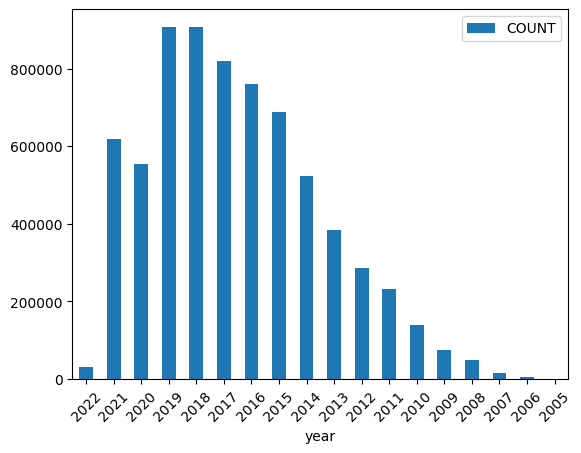

In [12]:
reviews_distribution_across_years.set_index("year").plot(kind="bar", rot=45)

In [15]:
business_restaurant_dir = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\yelp\\business_restaurante.parquet"
business_full_DS = spark.read.parquet(business_restaurant_dir)

In [16]:
business_full_DS.createOrReplaceTempView("business")

In [17]:
business_full_DS.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: long (nullable = true)
 |-- is_open: long (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking:

In [18]:
spark.catalog.listTables()

[Table(name='business', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='reviews', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [19]:
query_2 = """
SELECT count(name)
FROM business
"""
spark.sql(query_2).show()

+-----------+
|count(name)|
+-----------+
|      52268|
+-----------+



In [20]:
query_3 = """
SELECT *
FROM business
LIMIT 1
"""

spark.sql(query_3).show()

+--------------------+------------------+-----------+------------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|              name|    address|        city|state|postal_code|  latitude|  longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+------------------+-----------+------------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+--------------------+--------------------+
|MTSW4McQd7CbVtyjq...|St Honore Pastries|935 Race St|Philadelphia|   CA|      19107|39.9555052|-75.1555641|  4.0|          80|      1|{null, null, u'no...|[Restaurants, Foo...|{7:0-21:0, 7:0-20...|
+--------------------+------------------+-----------+------------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+--------------------+--------------------+



In [21]:
query_4 = """
SELECT *
FROM reviews
LIMIT 5
"""

spark.sql(query_4).show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [22]:
query_5 = """
SELECT *
FROM reviews
WHERE YEAR(date) BETWEEN '2015' AND '2022'
"""

reviews_2015_2022 = spark.sql(query_5)

In [33]:
reviews_2015_2022.createOrReplaceTempView("reviews_2015_2022")

In [34]:
spark.catalog.listTables()

[Table(name='business', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='reviews', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='reviews_2015_2022', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [25]:
reviews_2015_2022_output_dir = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\yelp\\reviews_2015_2022.parquet"
reviews_2015_2022.write.parquet(reviews_2015_2022_output_dir)

Py4JJavaError: An error occurred while calling o88.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:651)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:288)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:793)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Ljava/lang/String;I)Z
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1218)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1423)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.parquet.hadoop.ParquetOutputCommitter.commitJob(ParquetOutputCommitter.java:48)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$26(FileFormatWriter.scala:277)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:642)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:277)
	... 42 more
